# P3: Behavior Cloning

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import csv
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


## 1. Load training data

I'm using the training data provided instead of using my own, since I find it difficult to control the car using keyboard, and I don't have a game controller.

In [2]:
# read data from csv file

samples = []
with open('data/driving_log.csv','rt') as f:
    reader = csv.reader(f)
    for line in reader:
        samples.append(line)
labels = samples.pop(0)

### 1.1 Data visualisation

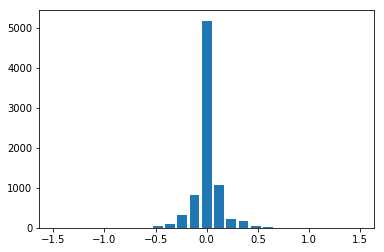

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.00000000e+00   1.00000000e+00   4.00000000e+00   4.00000000e+00
   5.50000000e+01   9.60000000e+01   3.24000000e+02   8.31000000e+02
   5.18600000e+03   1.07100000e+03   2.26000000e+02   1.82000000e+02
   3.80000000e+01   1.10000000e+01   1.00000000e+00   0.00000000e+00
   2.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [3]:
# extract steering angles and plot histogram

steering_angles = [float(samples[i][3]) for i in range(len(samples))]
n_bins = 25

fig = plt.figure()
ax = fig.add_subplot(111)
(n, bins, patches) = ax.hist(steering_angles,n_bins, range = (-1.5,1.5), rwidth = 0.8)
plt.show()

print(n)

As can be seen from the above histogram, the steering angles in the provided training data are extremely concentrated around zero, and slightly skewed towards positive values. If we train using this data as it is, the car driven by trained model might not be able to steer through sharp turns, and even moderate turns towards the right (because of skew towards left).
Therefore we augment the data next to spread the steering angles, and make it symmetric.

## 2. Data Augmentation

Data is augmented using two techniques: 
- First is using the left and right images, and using a correction factor for the steering angle so that these images can be effectively treated as center images.
- Second is left-right flipping of the images, while inverting the steering angle. Image flipping also removes the bias of steering angles towards one direction. Note that the actual image flipping will be done when we read the images using `generator`, but here we just invert the angle and add a tag to indicate if the image needs to be flipped or not. 

In [4]:
# data augmentation

augmented_samples = []

# correction factor for using left and right image
correction = 0.2

for i in range(len(samples)):
    
    # image flipping will be done while reading image data in generator
    # here, only the angle is flipped, and a tag is added
    
    for flipped in [-1,1]:
        
        # center image
        augmented_samples.append([samples[i][0], flipped*float(samples[i][3]), flipped])
        
        # left image
        augmented_samples.append([samples[i][1], flipped*(float(samples[i][3])+correction), flipped])
        
        # right image
        augmented_samples.append([samples[i][2], flipped*(float(samples[i][3])- correction), flipped])
    

### 2.1 Visualisation of Augmented Data

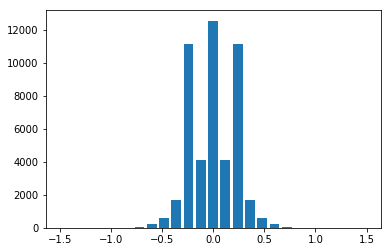

[  0.00000000e+00   0.00000000e+00   4.00000000e+00   2.00000000e+00
   1.00000000e+01   1.70000000e+01   5.70000000e+01   2.33000000e+02
   5.73000000e+02   1.65900000e+03   1.11550000e+04   4.11900000e+03
   1.25580000e+04   4.11900000e+03   1.11550000e+04   1.65900000e+03
   5.73000000e+02   2.33000000e+02   5.70000000e+01   1.70000000e+01
   1.00000000e+01   2.00000000e+00   4.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [5]:
# plot histogram of steering angles after data augmentation

augmented_angles = [augmented_samples[i][1] for i in range(len(augmented_samples))]
n_bins = 25

fig = plt.figure()
ax = fig.add_subplot(111)
(n, bins, patches) = ax.hist(augmented_angles,n_bins, range = (-1.5,1.5), rwidth = 0.8)
plt.show()

print(n)

After data augmentation, the histogram for steering angles has clearly become more spread out, and completely symmetric.

## 3. Split Augmented Data into Training and Validation Sets

In [6]:
shuffle(augmented_samples, random_state = 12)
training_samples, validation_samples = train_test_split(augmented_samples, test_size=0.1, random_state = 12)
print("Size of validation set is: " + str(len(validation_samples)))

Size of validation set is: 4822


I use a relatively small `test_size` of 0.1, since even this small percentage results in around 5000 samples for validation, and also because I want to loose as few samples as possible for large steering angles - samples which are too few even after data augmentation.  

## 4. Image Preprocessing

For image preprocessing before training, I first downscale the image to (64,32) size, and then take only the H and S channels since these channels are the most useful for lane finding, and by removing the V channel, we eliminate the impact of brightness. We also crop the image to remove the unnecessary top (sky) and bottom (bonnet) pixels, and finally normalize so that all the values are between 0.5 and -0.5.

In [7]:
def image_preprocessing(img):
    
    # downscale the image
    image = cv2.resize(img, (64, 32))
    
    # convert to HSV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
       
    # crop image and retain only H and S channels
    image = image[8:28,:,:2]
    
    # normalize
    image = image / 255. - 0.5
    image = np.array(image)
    
    return image

### 4.1 Image visualisation before and after preprocessing

Since I did not find a way to visualise an image having two channels - H and S, I will visualise the preprocessed images when only one of two channels is retained. 

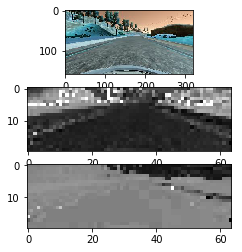

In [8]:
# image visualisation after preprocessing (separate visualisation of H and S channels)

# choose a random image
rand = np.random.randint(len(training_samples))
path_file = training_samples[rand][0]
img = cv2.imread(path_file.strip())

# H channel
h_image = np.array(((cv2.cvtColor(cv2.resize(img,(64,32)), cv2.COLOR_RGB2HSV))[8:28,:,0])/255. - 0.5)

# S channel
s_image = np.array(((cv2.cvtColor(cv2.resize(img,(64,32)), cv2.COLOR_RGB2HSV))[8:28,:,1])/255. - 0.5)

plt.subplot(3,1,1)
plt.imshow(img)
plt.subplot(3,1,2)
plt.imshow(s_image, cmap = 'gray')
plt.subplot(3,1,3)
plt.imshow(h_image, cmap = 'gray')

## 5. Generator for Batches of Training and Validation Samples

Since loading all the training images into memory simultaneously would require huge memory, I define a generator to load images simultaneously only for batches of training and validation sets.

In [9]:
def X_generator(samples, batch_size=32):
    
    num_samples = len(samples)
    
    while 1: # Loop forever so the generator never terminates     
        
        shuffle(samples, random_state = 12)
        
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                
                # Read image using the file path
                image = cv2.imread(batch_sample[0].strip())
                
                # Flip the image, if the tag is -1                
                if batch_sample[2] == -1:
                    image = cv2.flip(image, 1)
                    
                # Preprocess image
                image = image_preprocessing(image)
                                
                # Read the corresponding steering angle
                angle = batch_sample[1]
                
                images.append(image)
                angles.append(angle)

            X = np.array(images)
            y = np.array(angles)
            
            yield (X, y)

In [10]:
# Initialise the training and validation generators

train_generator = X_generator(training_samples, batch_size=256)
validation_generator = X_generator(validation_samples, batch_size=256)

## 6. Neural Network Model

I started with the LeNet architecture, which resulted in a model which could not successfully drive the car. Even though the image preprocessing step has fairly simplified and reduced the size of input, the reason for poor performance might be that the number of parameters are too large to generalise well using the given training data. Therefore, instead of trying the more complicated network like that proposed by NVIDIA for real cars, I decided to trim the network to reduce the number of parameters. The resulting network consists of one convolution layer (same as the one from LeNet architecture), followed by MaxPooling (as in LeNet) and Dropout (not present in LeNet) layers to prevent overfitting, and finally one small fully connected layer (size drastically reduced compared to LeNet).

In [11]:
def LeNet_mod(inp_shape):

    model = Sequential()
    
    # Convolution layer of 6 filters of size (5, 5) followed by Maxpooling layer - same as LeNet architecture
    model.add(Conv2D(6, 5, 5, border_mode='valid',input_shape=inp_shape, activation='relu'))
    model.add(MaxPooling2D())
    
    # Additional dropout layer to prevent overfitting
    model.add(Dropout(0.25))    

    model.add(Flatten())

    # Fully connected layer with reduced size compared to LeNet
    model.add(Dense(4, activation='relu'))   

    model.add(Dense(1))
    
    return model

In [12]:
# Initialise the model for training

model = LeNet_mod((20, 64, 2))

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 60, 6)     306         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 30, 6)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 8, 30, 6)      0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1440)          0           dropout_1[0][0]                  
___________________________________________________________________________________________

## 7. Training the Neural Network Model

In [14]:
# Use the Adam optimizer and MSE as the loss function 

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(training_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=20)

Epoch 1/20
43394/43394 [==============================] - 119s - loss: 0.0479 - val_loss: 0.0430
Epoch 2/20
43394/43394 [==============================] - 105s - loss: 0.0358 - val_loss: 0.0213
Epoch 3/20
43394/43394 [==============================] - 101s - loss: 0.0213 - val_loss: 0.0185
Epoch 4/20
43394/43394 [==============================] - 103s - loss: 0.0194 - val_loss: 0.0177
Epoch 5/20
43394/43394 [==============================] - 97s - loss: 0.0187 - val_loss: 0.0173
Epoch 6/20
43394/43394 [==============================] - 83s - loss: 0.0182 - val_loss: 0.0168
Epoch 7/20
43394/43394 [==============================] - 101s - loss: 0.0178 - val_loss: 0.0164
Epoch 8/20
43394/43394 [==============================] - 111s - loss: 0.0175 - val_loss: 0.0162
Epoch 9/20
43394/43394 [==============================] - 101s - loss: 0.0174 - val_loss: 0.0160
Epoch 10/20
43394/43394 [==============================] - 105s - loss: 0.0171 - val_loss: 0.0159
Epoch 11/20
43394/43394 [======

### 7.1 Plot the Training and Validation Loss

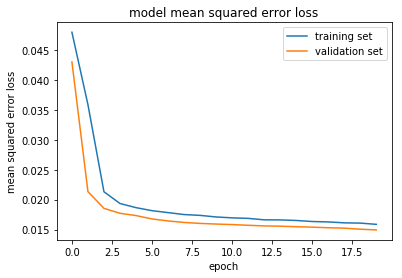

In [15]:
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

I used number of epochs to be 20 to get clearer trends in the plot of training and validation loss, but from the plot, it is clear that even taking number of epochs to be 5 should be sufficient to train the model to successfully drive the car.

### 7.2 Saving the Trained Model

In [16]:
model.save("model.h5")
print("Model saved.")

Model saved.


## Testing the Trained Model

For testing, I consider only Track 1, since I don't have (and cannot generate due to lack of game controller) training data for Track 2. A model passes the test if it can successfully drive the car for a few laps on Track 1. 

LeNet architecture and most of its modifications that I tried faltered at one or other point of the Track, sometimes on the second or third lap. However, the architecture presented here did well for indefinite time. 

I also tried to tune the correction factor for left and right images. Correction of 0.3 also worked, but resulted in more wobbly trajectory, while correction of 0.1 resulted in car unable to negotiate sharp turns. Therefore, I decided to stick with the correction suggested in the project guidelines, that is, 0.2. 

The run I recorded for this architecture is saved in video.mp4.

Also note that the file drive.py has been modify to appropriately preprocess the image before feeding into the model.